# importing libraries

In [2]:
import sys
sys.path.insert(1, '/gh/kaggle-pg-3x26')
import zipfile
import pandas as pd

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
import pickle
import src.functions as func
import requests
import seaborn as sn
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction import DictVectorizer

In [3]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# getting data

In [5]:
with zipfile.ZipFile("/gh/kaggle-pg-3x26/data/playground-series-s3e26.zip") as z:
    with z.open("sample_submission.csv") as f:
        sample_submission = pd.read_csv(f)
    with z.open("test.csv") as f:
        test = pd.read_csv(f)
    with z.open("train.csv") as f:
        train = pd.read_csv(f)

# exploring data

## data types

In [7]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         5271 non-null   int64  
 1   Status_C   5271 non-null   float64
 2   Status_CL  5271 non-null   float64
 3   Status_D   5271 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 164.8 KB


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5271 non-null   int64  
 1   N_Days         5271 non-null   int64  
 2   Drug           5271 non-null   object 
 3   Age            5271 non-null   int64  
 4   Sex            5271 non-null   object 
 5   Ascites        5271 non-null   object 
 6   Hepatomegaly   5271 non-null   object 
 7   Spiders        5271 non-null   object 
 8   Edema          5271 non-null   object 
 9   Bilirubin      5271 non-null   float64
 10  Cholesterol    5271 non-null   float64
 11  Albumin        5271 non-null   float64
 12  Copper         5271 non-null   float64
 13  Alk_Phos       5271 non-null   float64
 14  SGOT           5271 non-null   float64
 15  Tryglicerides  5271 non-null   float64
 16  Platelets      5271 non-null   float64
 17  Prothrombin    5271 non-null   float64
 18  Stage   

In [10]:
train.head(3).T

0        1        2
id                           0        1        2
N_Days                     999     2574     3428
Drug           D-penicillamine  Placebo  Placebo
Age                      21532    19237    13727
Sex                          M        F        F
Ascites                      N        N        N
Hepatomegaly                 N        N        Y
Spiders                      N        N        Y
Edema                        N        N        Y
Bilirubin                  2.3      0.9      3.3
Cholesterol              316.0    364.0    299.0
Albumin                   3.35     3.54     3.55
Copper                   172.0     63.0    131.0
Alk_Phos                1601.0   1440.0   1029.0
SGOT                     179.8   134.85   119.35
Tryglicerides             63.0     88.0     50.0
Platelets                394.0    361.0    199.0
Prothrombin                9.7     11.0     11.7
Stage                      3.0      3.0      4.0
Status                       D        C        D

## one hot encoder in output

In [12]:
cat_encoder = OneHotEncoder(sparse_output=False)
cat_1hot = cat_encoder.fit_transform(train[["Status"]])
train[cat_encoder.get_feature_names_out()] = cat_1hot

## exploring features

In [14]:
train.describe(include="all").T

count unique      top  freq         mean          std     min  \
id             7905.0    NaN      NaN   NaN       3952.0  2282.121272     0.0   
N_Days         7905.0    NaN      NaN   NaN  2030.173308  1094.233744    41.0   
Drug             7905      2  Placebo  4010          NaN          NaN     NaN   
Age            7905.0    NaN      NaN   NaN  18373.14649  3679.958739  9598.0   
Sex              7905      2        F  7336          NaN          NaN     NaN   
Ascites          7905      2        N  7525          NaN          NaN     NaN   
Hepatomegaly     7905      2        Y  4042          NaN          NaN     NaN   
Spiders          7905      2        N  5966          NaN          NaN     NaN   
Edema            7905      3        N  7161          NaN          NaN     NaN   
Bilirubin      7905.0    NaN      NaN   NaN     2.594485      3.81296     0.3   
Cholesterol    7905.0    NaN      NaN   NaN   350.561923   195.379344   120.0   
Albumin        7905.0    NaN      NaN   NaN     3.548323     0.346171    1.96   
Copper         7905.0    NaN      NaN   NaN    83.902846    75.899266     4.0   
Alk_Phos       7905.0    NaN      NaN   NaN   1816.74525  1903.750657   289.0   
SGOT           7905.0    NaN      NaN   NaN   114.604602    48.790945   26.35   
Tryglicerides  7905.0    NaN      NaN   NaN   115.340164    52.530402    33.0   
Platelets      7905.0    NaN      NaN   NaN   265.228969    87.465579    62.0   
Prothrombin    7905.0    NaN      NaN   NaN    10.629462     0.781735     9.0   
Stage          7905.0    NaN      NaN   NaN     3.032511     0.866511     1.0   
Status           7905      3        C  4965          NaN          NaN     NaN   
Status_C       7905.0    NaN      NaN   NaN     0.628083     0.483347     0.0   
Status_CL      7905.0    NaN      NaN   NaN     0.034788     0.183254     0.0   
Status_D       7905.0    NaN      NaN   NaN     0.337128     0.472759     0.0   

                   25%      50%      75%      max  
id              1976.0   3952.0   5928.0   7904.0  
N_Days          1230.0   1831.0   2689.0   4795.0  
Drug               NaN      NaN      NaN      NaN  
Age            15574.0  18713.0  20684.0  28650.0  
Sex                NaN      NaN      NaN      NaN  
Ascites            NaN      NaN      NaN      NaN  
Hepatomegaly       NaN      NaN      NaN      NaN  
Spiders            NaN      NaN      NaN      NaN  
Edema              NaN      NaN      NaN      NaN  
Bilirubin          0.7      1.1      3.0     28.0  
Cholesterol      248.0    298.0    390.0   1775.0  
Albumin           3.35     3.58     3.77     4.64  
Copper            39.0     63.0    102.0    588.0  
Alk_Phos         834.0   1181.0   1857.0  13862.4  
SGOT             75.95    108.5   137.95   457.25  
Tryglicerides     84.0    104.0    139.0    598.0  
Platelets        211.0    265.0    316.0    563.0  
Prothrombin       10.0     10.6     11.0     18.0  
Stage              2.0      3.0      4.0      4.0  
Status             NaN      NaN      NaN      NaN  
Status_C           0.0      1.0      1.0      1.0  
Status_CL          0.0      0.0      0.0      1.0  
Status_D           0.0      0.0      1.0      1.0

In [15]:
train.drop("id",axis=1,inplace=True)

In [16]:
train.columns

Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Status',
       'Status_C', 'Status_CL', 'Status_D'],
      dtype='object')

In [17]:
categorical_variables = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema"]

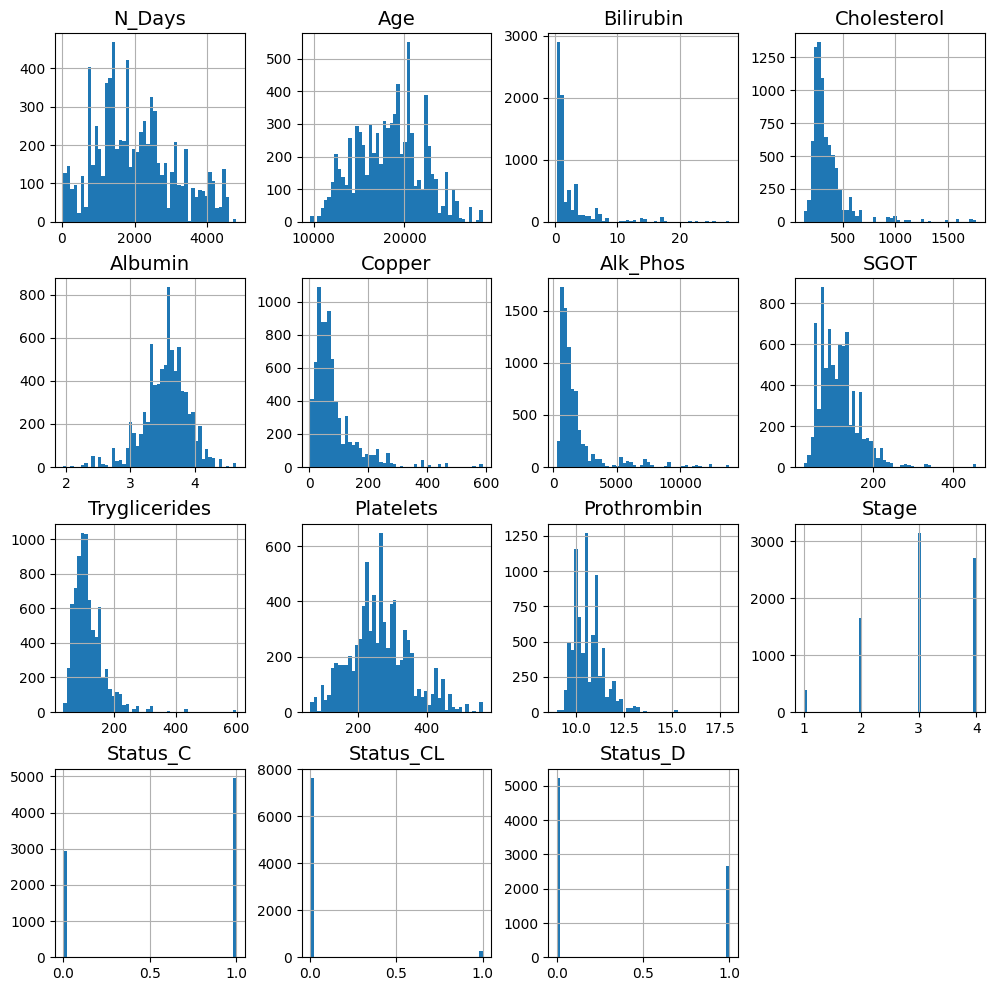

In [19]:
train.hist(bins=50, figsize=(12, 12))
plt.show()

In [20]:
numerical_variables = list()
for col in list(train.columns):
    if col not in categorical_variables:
        numerical_variables.append(col)

In [21]:
numerical_variables

['N_Days',
 'Age',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin',
 'Stage',
 'Status',
 'Status_C',
 'Status_CL',
 'Status_D']

In [25]:

numerical_variables.remove("Status")

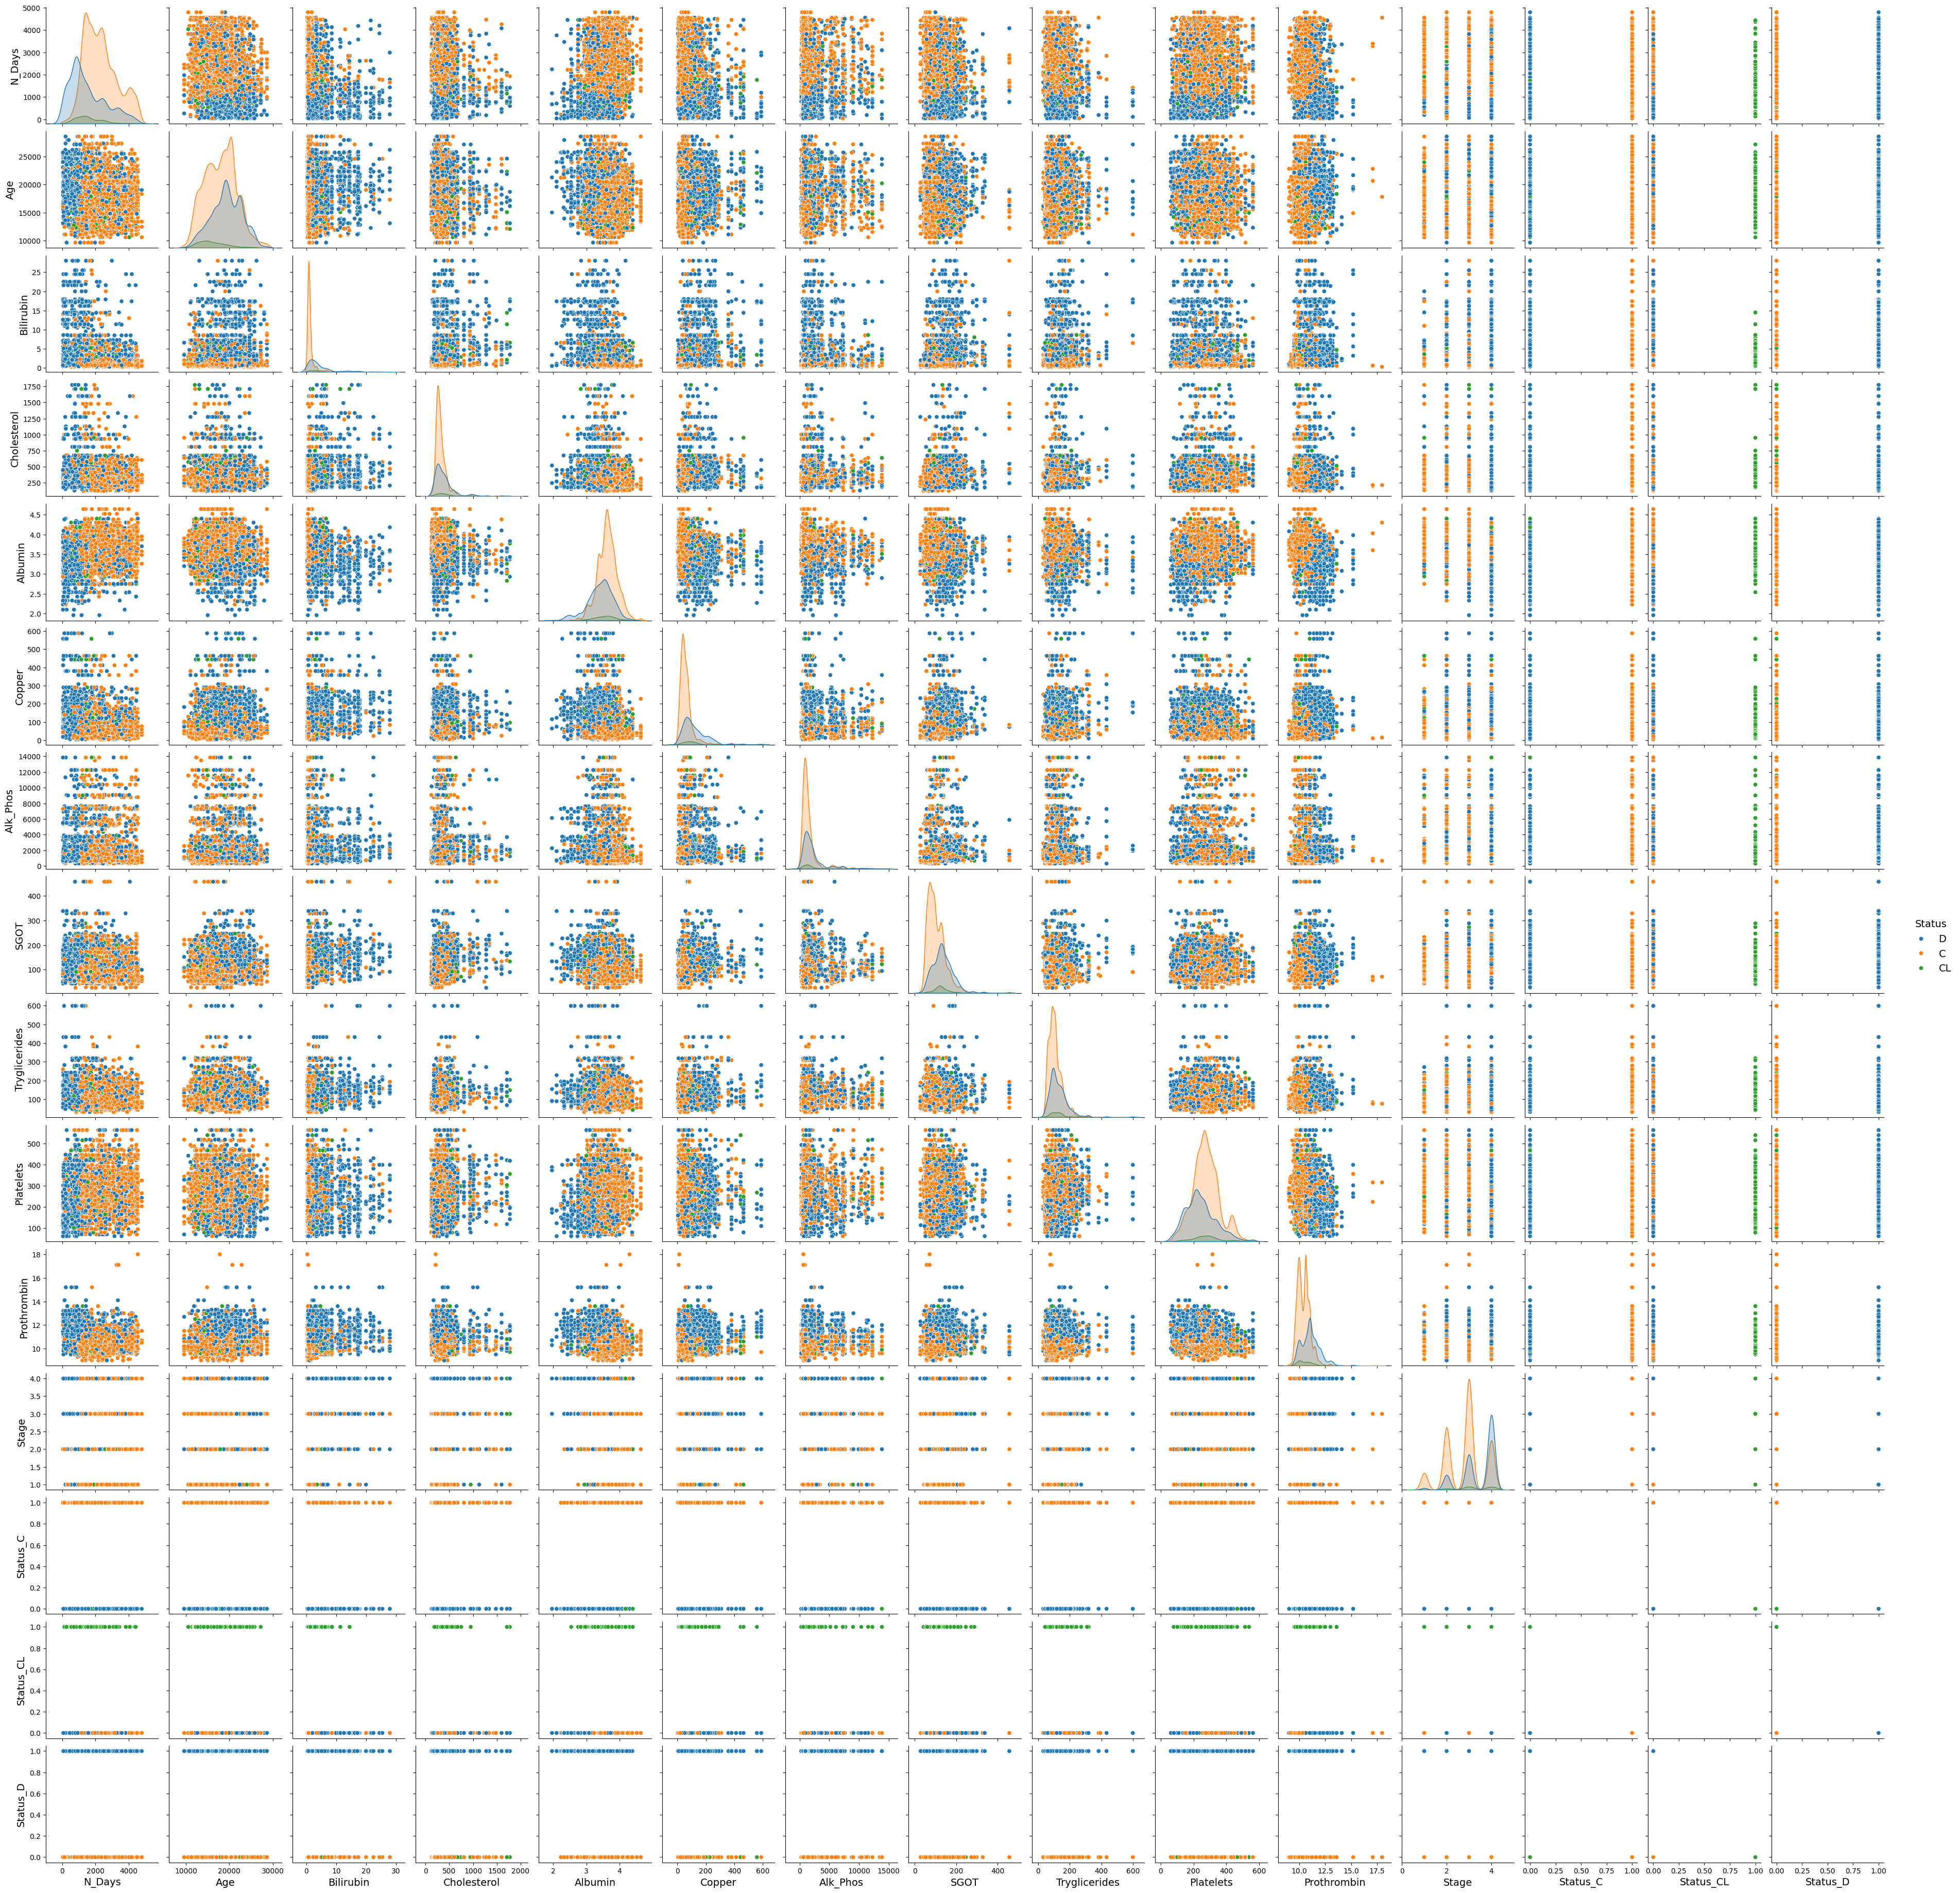

In [26]:
sns.pairplot(train[numerical_variables+["Status"]], hue="Status")